# **Solving Elliptic HJB Equations in A Value Space**

The report can be found in:

[Report](https://github.com/cengaiyeung/20MA573/blob/master/Final/MA_573.pdf)

And the code is as follows:

In [0]:
import time
import math
import random
import numpy as np
import matplotlib.pyplot as plt   
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import itertools

In [0]:
## PDE class, define the drift, run cost l^{h}(x), terminal cost and the exact solution of PDE

class Pde:
    def __init__(self, n_dim = 2, verbatim = False):
        self.n_dim = n_dim    
        self.lam = 0.
        self.domain = [0,1]
        
        if verbatim == True:
            print('>>> n_dim: '+str(n_dim))
            print('>>> domain: ' + str(self.domain))
            
    drift = lambda self,s,a: a
    
    run_cost = lambda self,s,a: (
            self.n_dim + sum([s1**2 for s1 in s])*2.0 
            + sum([a1**2 for a1 in a])/2.0
            )
    
    term_cost = lambda self,s: - sum([s1**2 for s1 in s]) 
    exact_soln = lambda self,s: - sum([s1**2 for s1 in s]) 

In [0]:
## Transform the PDE into MDP by the CFD scheme or UFD scheme

class Mdp(Pde):
    def __init__(self, n_dim = 2, n_mesh = 8, verbatim = False):
        super().__init__(n_dim, verbatim)
        self.n_mesh= n_mesh  
        self.totn_mesh = self.n_mesh*(self.domain[1]-self.domain[0])
        self.h_mesh = 1./self.n_mesh #mesh size
        self.v_shape = tuple([self.totn_mesh+ 1,]*self.n_dim)
        if verbatim == True:
            print('>>> n_mesh: '+str(n_mesh)
                  +' totn_mesh: '+ str(self.totn_mesh))


    #input: list of index
    #return: physicial coordinate

    def i2s(self,ix): 
        return [x * self.h_mesh+self.domain[0] for x in ix]
    
    def is_interior(self,ix):
        return all(map(lambda a: 0<a<self.totn_mesh, ix))
        
    #input: lists of index and action
    #return: discount rate, running cost, list of next index, list of probability

    def step(self, ix, a, fd='cfd'):
        ix = list(ix)
        s = self.i2s(ix)
        b = Pde.drift(Pde, s, a)
        if fd=='cfd':
            lam = self.n_dim/(self.n_dim+self.lam*(self.h_mesh**2))
            run_cost_h = self.h_mesh**2*self.run_cost(s,a)/self.n_dim
            
            ix_next = []; pr_next= []
            #cfd
            if self.is_interior(ix):
                for i in range(self.n_dim):
                    ix1 = ix.copy(); ix1[i]+=1; ix_next += [ix1,]
                    pr1 = (1+self.h_mesh*b[i])/(self.n_dim*2.0)
                    pr_next += [pr1,]
                for i in range(self.n_dim):
                    ix1 = ix.copy(); ix1[i]-=1; ix_next += [ix1,]
                    pr1 = (1-self.h_mesh*b[i])/(self.n_dim*2.0)
                    pr_next += [pr1,]
        elif fd=='ufd':
            c = self.n_dim - sum([abs(b1) for b1 in b])*self.h_mesh
            b_plus = [(abs(b1)+b1)/2. for b1 in b]
            b_minus = [(abs(b1)-b1)/2. for b1 in b]
            lam = c/(c+self.h_mesh**2*self.lam)
            run_cost_h = self.h_mesh**2*self.run_cost(s,a)/c
            ix_next = []; pr_next= []
            #ufd
            if self.is_interior(ix):
                for i in range(self.n_dim):
                    ix1 = ix.copy(); ix1[i]+=1; ix_next += [ix1,]
                    pr1 = (1-2.*self.h_mesh*b_minus[i])/(c*2.0) 
                    pr_next += [pr1,]
                for i in range(self.n_dim):
                    ix1 = ix.copy(); ix1[i]-=1; ix_next += [ix1,]
                    pr1 = (1-2.*self.h_mesh*b_plus[i])/(c*2.0) 
                    pr_next += [pr1,]        
        return lam, run_cost_h, ix_next, pr_next
    
    def step_random(self, ix, a, fd='cfd'):
        lam, run_cost, ix_next, pr_next = self.step(ix, a, fd)
        ix_next_rand = random.choices(ix_next, pr_next, k = 1)
        return lam, run_cost, ix_next_rand[0]   

In [0]:
## supplemental tools

def deep_iter(*shape):
    iters = (range(i) for i in shape)
    return itertools.product(*iters)


## product of a list

def product(l):
    out = 1
    for x in l:
        out *= x
    return out


In [0]:
## The methods to solve the MDP

class Solver(Mdp):
    def __init__(self, n_dim = 1, n_mesh = 8, fd = 'ufd', verbatim = False):
        super().__init__(n_dim, n_mesh, verbatim)
        self.fd = fd
        #value iteration init
        self.v = np.zeros(self.v_shape) #init
        self.as_ratio= 3
        self.a_space = tuple([self.as_ratio*self.totn_mesh+1,]*n_dim)
        self.p_shape = tuple(list(self.v_shape)+[self.n_dim,])
        self.policy = np.zeros(self.p_shape) #init
        self.tol = 1e-5; self.max_iter = 1000
        
        #boundary value
        for ix in deep_iter(*self.v_shape):
            if not self.is_interior(ix):
                self.v[ix] = self.term_cost(self.i2s(ix))
    
    
    def i2a(self, ix):
        ix = list(ix)
        return [ix1*self.h_mesh+self.as_ratio*self.domain[0] for ix1 in ix]
    
    #input:
        #list of index and action
    #return:
        #q_val assuming v is value

    def q_val(self, ix, a):
        lam, run_cost_h, ix_next, pr_next = self.step(ix,a,self.fd)
        out = run_cost_h
        for ix1, pr1 in zip(ix_next, pr_next):
            out+=pr1*self.v[tuple(ix1)]
        out *= lam
        return out

    #input:
        #list of index
    #return:
        #list of optimal action
        #corresponding q-value assuming v is value

    def greedy(self, ix):
        a_ix = [0,]*self.n_dim; out_v = self.q_val(ix, self.i2a(a_ix))
        for a_ix1 in deep_iter(*self.a_space):
            out_v1 = self.q_val(ix, self.i2a(a_ix1))
            if out_v1 < out_v:
                a_ix = a_ix1; out_v = out_v1
        return self.i2a(a_ix), out_v
                
        

    def value_iter(self):    
        for n_iter in range(self.max_iter):
            v_cp = np.copy(self.v)
            err = 0.
            for ix in deep_iter(*self.v_shape):
                if self.is_interior(ix):
                    out_a, out_v = self.greedy(ix)
                    self.policy[ix] = out_a; self.v[ix] = out_v
                    err += (v_cp[ix]-out_v)**2

            if err<self.tol:
                break
        return err, n_iter
    
    def plot1d(self):
        if self.n_dim==1:
            x_cod = np.zeros(self.v_shape)
            exact_val = np.zeros(self.v_shape)
            for ix in deep_iter(*self.v_shape):
                x_cod[ix] = self.i2s(list(ix))[0]
                exact_val[ix] = self.exact_soln(self.i2s(list(ix)))
                                
            plt.plot(x_cod, self.v, '--', label='aproximation')
            plt.plot(x_cod, exact_val, label='exact solution')
            plt.legend()
            plt.show()
    
    def plot2d(self):
        if self.n_dim==2:
            
            fig = plt.figure()
            ax = fig.gca(projection=Axes3D.name)
            x_cod = np.zeros(self.v_shape)
            y_cod = np.zeros(self.v_shape)
            z = self.v
            for ix in deep_iter(*self.v_shape):
                x_cod[ix] = self.i2s(list(ix))[0]
                y_cod[ix] = self.i2s(list(ix))[1]
            # Plot the surface.
            ax.plot_surface(x_cod, y_cod, z, 
                                      cmap=cm.coolwarm,
                                      linewidth=0, antialiased=False)
            plt.show()
                            
            
            
            
                    
    def l2err(self):
        err = 0.
        exact_val = np.zeros(self.v_shape)
        
        for ix in deep_iter(*self.v_shape):
            exact_val[ix] = self.exact_soln(self.i2s(list(ix)))
            err += (exact_val[ix]- self.v[ix])**2
        err = err/product(self.v_shape)
        return math.sqrt(err)        
    
    

>>> n_dim: 1
>>> domain: [0, 1]
>>> n_mesh: 8 totn_mesh: 8
>>>elapsed time: 0.034307241439819336
>>>running err:6.621465903706597e-06
>>>number of iterations: 22
>>>>L2 exact err:0.0037144258967895475


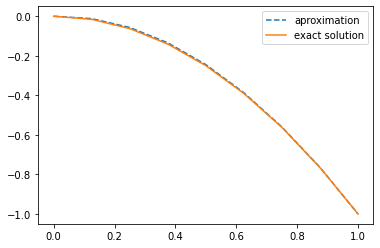

In [6]:
## value iteration
## 1 dimension, CFD scheme

startime = time.time() 
agt1 = Solver(n_dim=1, n_mesh= 8, fd='cfd', verbatim = True)
err, n_iter = agt1.value_iter()
endtime = time.time()


print('>>>elapsed time: ' + str(endtime-startime))
print('>>>running err:' +str(err))
print('>>>number of iterations: ' + str(n_iter))
print('>>>>L2 exact err:'+str(agt1.l2err()))
agt1.plot1d()

>>> n_dim: 2
>>> domain: [0, 1]
>>> n_mesh: 8 totn_mesh: 8
>>>elapsed time: 9.506543397903442
>>>running err:9.284547956696134e-06
>>>number of iterations: 29
>>>>L2 exact err:0.0014685064430707752


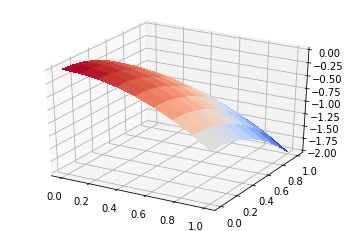

In [7]:
## value iteration
## 2 dimension, CFD scheme
startime = time.time() 
agt2 = Solver(n_dim=2, n_mesh= 8, fd='cfd', verbatim = True)
err, n_iter = agt2.value_iter()
endtime = time.time()


print('>>>elapsed time: ' + str(endtime-startime))
print('>>>running err:' +str(err))
print('>>>number of iterations: ' + str(n_iter))
print('>>>>L2 exact err:'+str(agt2.l2err()))
agt2.plot2d()

>>> n_dim: 1
>>> domain: [0, 1]
>>> n_mesh: 8 totn_mesh: 8
>>>elapsed time: 0.04780101776123047
>>>running err:6.876010351165338e-06
>>>number of iterations: 20
>>>>L2 exact err:0.022364237237426886


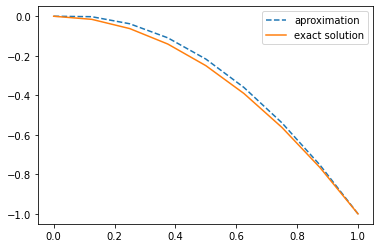

In [8]:
## value iteration
## 1 dimension, UFD scheme

startime = time.time() 
agt3 = Solver(n_dim=1, n_mesh= 8, fd='ufd', verbatim = True)
err, n_iter = agt3.value_iter()
endtime = time.time()


print('>>>elapsed time: ' + str(endtime-startime))
print('>>>running err:' +str(err))
print('>>>number of iterations: ' + str(n_iter))
print('>>>>L2 exact err:'+str(agt3.l2err()))
agt3.plot1d()

>>> n_dim: 2
>>> domain: [0, 1]
>>> n_mesh: 8 totn_mesh: 8
>>>elapsed time: 10.29446029663086
>>>running err:6.834716899377879e-06
>>>number of iterations: 28
>>>>L2 exact err:0.017207060296674424


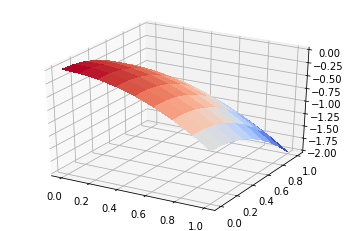

In [9]:
## value iteration
## 2 dimension, UFD scheme

startime = time.time() 
agt4 = Solver(n_dim=2, n_mesh= 8, fd='ufd', verbatim = True)
err, n_iter = agt4.value_iter()
endtime = time.time()


print('>>>elapsed time: ' + str(endtime-startime))
print('>>>running err:' +str(err))
print('>>>number of iterations: ' + str(n_iter))
print('>>>>L2 exact err:'+str(agt4.l2err()))
agt4.plot2d()

In [10]:
## value iteration
## 3 dimension, CFD scheme

startime = time.time() 
agt5 = Solver(n_dim=3, n_mesh= 4, fd='cfd', verbatim = True)
err, n_iter = agt5.value_iter()
endtime = time.time()


print('>>>elapsed time: ' + str(endtime-startime))
print('>>>running err:' +str(err))
print('>>>number of iterations: ' + str(n_iter))
print('>>>>L2 exact err:'+str(agt5.l2err()))

>>> n_dim: 3
>>> domain: [0, 1]
>>> n_mesh: 4 totn_mesh: 4
>>>elapsed time: 8.629664182662964
>>>running err:2.0457710006034087e-06
>>>number of iterations: 10
>>>>L2 exact err:8.779411822732991e-05


In [11]:
## value iteration
## 3 dimension, UFD scheme

startime = time.time() 
agt6 = Solver(n_dim=3, n_mesh= 4, fd='ufd', verbatim = True)
err, n_iter = agt6.value_iter()
endtime = time.time()


print('>>>elapsed time: ' + str(endtime-startime))
print('>>>running err:' +str(err))
print('>>>number of iterations: ' + str(n_iter))
print('>>>>L2 exact err:'+str(agt6.l2err()))

>>> n_dim: 3
>>> domain: [0, 1]
>>> n_mesh: 4 totn_mesh: 4
>>>elapsed time: 8.785469055175781
>>>running err:1.4690267737064107e-06
>>>number of iterations: 9
>>>>L2 exact err:0.022482698168242055
